In [1]:
%matplotlib inline
from matplotlib import style
style.use('ggplot')
# print(style.available)
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

<div class="alert alert-block alert-info">
<h3> <b><i>NOTE:</i><b> <br><br> Even though I set all the stuffs for ORM mapping,<br><br> I am going to use the combination of raw sql commands + pandas 'read_sql_query' for practice purpose. </h3>
    </div>

# Exploratory Climate Analysis

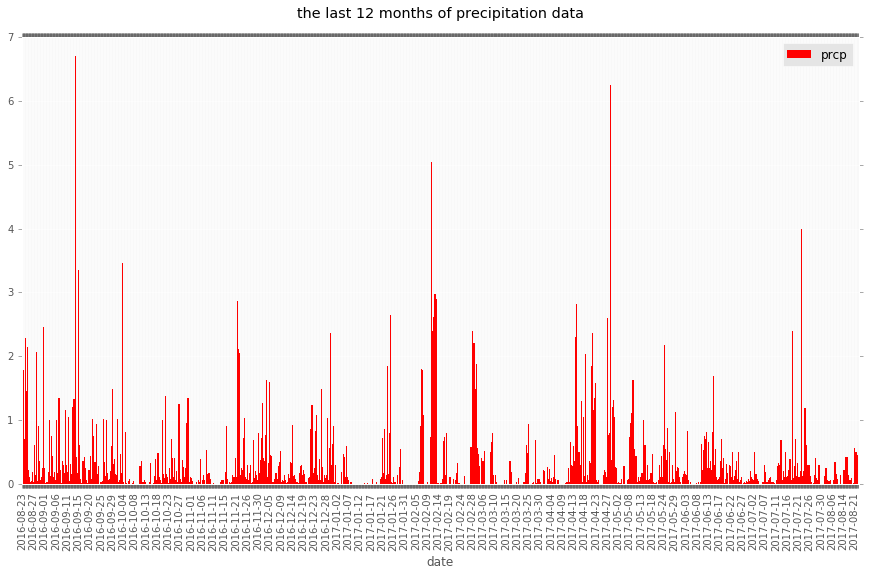

In [407]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

query = '''
        SELECT m.date,
               m.prcp
        FROM measurement AS m
        WHERE m.date >= date((SELECT MAX(m2.date) AS last_date FROM measurement AS m2), '-1 year')
'''

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql_query(query, engine)
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(1,1, figsize=(15,8))
df.plot.bar(ax=ax, color='red', width=3, edgecolor = "none")
plt.title("the last 12 months of precipitation data", pad=20)


# Reduce the number of xticks for readability
every_nth = 30
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [70]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [74]:
# Design a query to show how many stations are available in this dataset?
query = '''
        SELECT COUNT(DISTINCT m.station) AS "number of station"
         FROM measurement AS m
'''

station_count = pd.read_sql_query(query, engine)
station_count

,number of station
0,9


In [408]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = '''
        SELECT m.station,
               COUNT(*) AS activity
         FROM measurement AS m
         GROUP BY 1
         ORDER BY 2 DESC
'''

active_station = pd.read_sql_query(query, engine)
active_station

,station,activity
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [383]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

query = '''
        SELECT MIN(m.tobs) AS "Lowest temperature",
               AVG(m.tobs) AS "Average temperature",
               MAX(m.tobs) AS "Highest temperature"
         FROM measurement AS m
         WHERE m.station = 'USC00519281'         
'''

temperature_most_active_station = pd.read_sql_query(query, engine)
temperature_most_active_station

,Lowest temperature,Average temperature,Highest temperature
0,54.0,71.663781,85.0


station           USC00519281
Number of obs.           2772
Name: 0, dtype: object




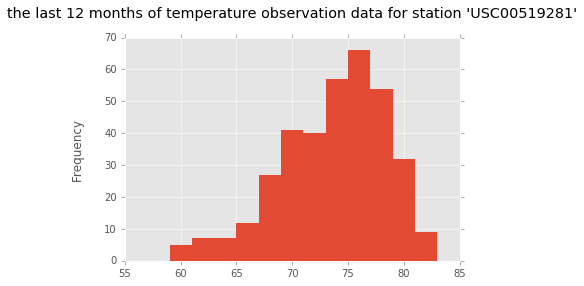

In [411]:
# Choose the station with the highest number of temperature observations.
# Design a query to ask for the number of temperature observations for each station
query = '''
        SELECT m.station,
               COUNT(m.tobs) AS "Number of obs."
         FROM measurement AS m
         GROUP BY 1
         ORDER BY 2 DESC
'''

number_temperature_obs = pd.read_sql_query(query, engine)
print(number_temperature_obs.iloc[0]) # The station 'USC00519281' has the highest number of temperature observations.

print("\n")  # line breaking for clarity

# Query the last 12 months of temperature observation data for station 'USC00519281' and plot the results as a histogram
query = '''
        SELECT m.tobs
         FROM measurement AS m
         WHERE (m.date >= date((SELECT MAX(m2.date)
                               FROM measurement AS m2
                               WHERE m2.station = 'USC00519281')
                               , '-1 year'))
         AND (m.station = 'USC00519281')
'''

temperature_most_active_station_1year = pd.read_sql_query(query, engine)
temperature_most_active_station_1year.hist(bins=12, edgecolor = "none")
plt.title("the last 12 months of temperature observation data for station 'USC00519281'", pad=20)
plt.ylabel('Frequency', labelpad=20);

<div class="alert alert-block alert-info">
<b><i>Note:</i></b> I am not going to use the function below.
</div>

In [404]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

<div class="alert alert-block alert-info">
<b><i>Note:</i></b> I rather create and use a new function to calculate basic stats on temperature for my trip since I want to practice raw sql commands more.
</div>

In [399]:
# Based on start date and end date of my trip in the format '%Y-%m-%d',
# calculate basic stats on temperature and output to a dataframe

def calc_temps_raw_sql(start_date, end_date):
    query = f'''
            SELECT MIN(m.tobs) AS Tmin,
                   AVG(m.tobs) AS Tavg,
                   MAX(m.tobs) AS Tmax
             FROM measurement AS m
             WHERE m.date >= '{start_date}' AND
                   m.date <= '{end_date}'
    '''
    
    return pd.read_sql_query(query, engine)

In [401]:
# Extract and unpack the basic stats from the dataframe output

for row in calc_temps_raw_sql('2017-08-07', '2017-08-21').iterrows():
    Tmin, Tavg, Tmax = row[1]

In [405]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# print(calc_temps('2017-08-07', '2017-08-21')) # Tmin, Tavg, and Tmax temperature
# Tmin, Tavg, Tmax = np.ravel(calc_temps('2017-08-07', '2017-08-21'))

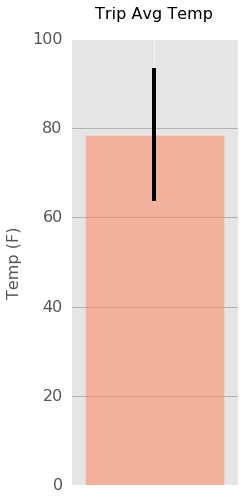

In [402]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=(3,8))

ax.bar(x=0, height=Tavg, width=0.1, yerr=(Tmax-Tmin),
       color='coral', alpha=0.5, tick_label=[""],
       error_kw=dict(ecolor='black', elinewidth=4, capsize=0))

plt.title("Trip Avg Temp", fontsize=16, pad=20)
plt.ylabel("Temp (F)", fontsize=16, labelpad=10)
plt.tick_params(labelsize=16,
                which='both', top=False, left=False, right=False, bottom=False) # Remove all ticks
ax.grid(axis='y', color='grey')

In [216]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query = '''
        SELECT s.station,
               s.name,
               s.latitude,
               s.longitude,
               s.elevation,
               sq.total_rainfall
         FROM station AS s
         LEFT JOIN (SELECT m.station,
                           SUM(m.prcp) AS total_rainfall
                     FROM measurement AS m
                     WHERE m.date >= date('2017-08-07') AND
                           m.date <= date('2017-08-21')
                     GROUP BY 1 ) AS sq
              ON s.station == sq.station
         ORDER BY 6 DESC
'''

rainfall_per_station_for_mytrip = pd.read_sql_query(query, engine)
rainfall_per_station_for_mytrip

,station,name,latitude,longitude,elevation,total_rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.59
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.51
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.26
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.14
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,NaN
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN


## Optional Challenge Assignment

<div class="alert alert-block alert-info">
<b><i>Note:</i></b> I am not going to use the function below.
</div>

In [406]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
# daily_normals("01-01")

<div class="alert alert-block alert-info">
<b><i>Note:</i></b> I rather create and use a new function to calculate the daily normals since I want to practice raw sql commands more.
</div>

In [10]:
# calculate the daily normals for your trip using raw sql commands, not ORM commands
# Create a function to handle a single date and apply a decorator to compute a list of dates at once.

def mapper(func):
    def inner(list_of_dates):
        return pd.concat([func(date) for date in list_of_dates])
    return inner

@mapper
def daily_normals_raw_sql(date):
    query = f'''
             SELECT MIN(m.tobs) AS Tmin,
                    AVG(m.tobs) AS Tavg,
                    MAX(m.tobs) AS Tmax
              FROM measurement AS m
              WHERE strftime('%m-%d', m.date) == '{date}'
    '''
    return pd.concat([pd.DataFrame({'Date' : ['2018-' + date]}),
                      pd.read_sql_query(query, engine)],
                      axis=1).set_index('Date')

In [11]:
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings

numdays = 15   # From Aug 07 to Aug 21
date_list = ["08-0" + str(7 + x)
             if (7 + x) < 10 else "08-" + str(7 + x)
             for x in range(numdays)]

# Loop through the list of %m-%d strings and calculate the normals for each date
# Save the results as a dataframe using pd.concat and list comprehension with the function

df_daily_normals_for_mytrip = daily_normals_raw_sql(date_list)
df_daily_normals_for_mytrip

,Tmin,Tavg,Tmax
Date,,,
2018-08-07,71.0,77.156863,83.0
2018-08-08,68.0,76.557692,83.0
2018-08-09,69.0,75.980392,81.0
2018-08-10,65.0,76.420000,83.0
2018-08-11,67.0,75.981132,82.0
2018-08-12,67.0,76.527273,83.0
2018-08-13,71.0,76.982456,84.0
2018-08-14,71.0,76.777778,82.0
2018-08-15,69.0,76.471698,83.0


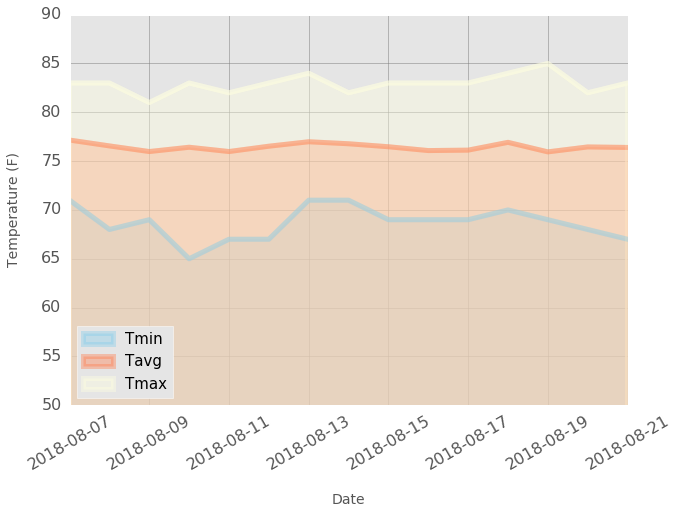

In [339]:
# Plot the daily normals as an area plot with `stacked=False`

fig, ax = plt.subplots(figsize=(10, 7))
df_daily_normals_for_mytrip.plot(kind='area', stacked=False, ax=ax,
                                 color=['skyblue', 'coral', 'lightyellow'], alpha=0.4, linewidth=5)

plt.xlabel("Date", fontsize=14, labelpad=20)
plt.ylabel("Temperature (F)", fontsize=14, labelpad=20)
plt.ylim([50,90])
plt.tick_params(labelsize=16,
                which='both', top=False, left=False, right=False, bottom=False) # Remove all ticks
plt.xticks(rotation=30)
plt.legend(fontsize=15, loc="lower left")
plt.grid(color='grey')

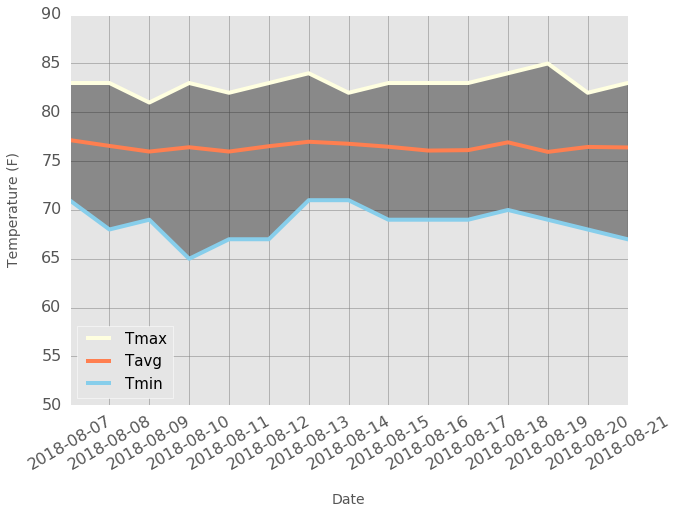

In [382]:
# Plot a line chart with the same data using fill_between method

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(df_daily_normals_for_mytrip.index, df_daily_normals_for_mytrip.Tmax, c='lightyellow', lw=4)
ax.plot(df_daily_normals_for_mytrip.index, df_daily_normals_for_mytrip.Tavg, c='coral', lw=4)
ax.plot(df_daily_normals_for_mytrip.index, df_daily_normals_for_mytrip.Tmin, c='skyblue', lw=4)
ax.fill_between(x=df_daily_normals_for_mytrip.index, y1='Tmax', y2='Tmin',
                 data=df_daily_normals_for_mytrip, alpha=0.4, color='k')


plt.xlabel("Date", fontsize=14, labelpad=20)
plt.ylabel("Temperature (F)", fontsize=14, labelpad=20)
plt.ylim([50,90])
plt.tick_params(labelsize=16,
                which='both', top=False, left=False, right=False, bottom=False) # Remove all ticks
plt.xticks(rotation=30)
plt.legend(fontsize=15, loc="lower left")
plt.grid(color='grey')